# Adult dataset preprocessing
#### Author: Josep de Cid Rodríguez

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import read_dataset

%matplotlib inline

In [127]:
dataset = read_dataset('adult')
data = dataset['data']

[ 0/1] Reading adult dataset...


In [141]:
df = pd.DataFrame(data)
df = df.drop(columns=['class'])
df = df.replace(b'?', np.nan)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,b'Private',226802.0,b'11th',7.0,b'Never-married',b'Machine-op-inspct',b'Own-child',b'Black',b'Male',0.0,0.0,40.0,b'United-States'
1,38.0,b'Private',89814.0,b'HS-grad',9.0,b'Married-civ-spouse',b'Farming-fishing',b'Husband',b'White',b'Male',0.0,0.0,50.0,b'United-States'
2,28.0,b'Local-gov',336951.0,b'Assoc-acdm',12.0,b'Married-civ-spouse',b'Protective-serv',b'Husband',b'White',b'Male',0.0,0.0,40.0,b'United-States'
3,44.0,b'Private',160323.0,b'Some-college',10.0,b'Married-civ-spouse',b'Machine-op-inspct',b'Husband',b'Black',b'Male',7688.0,0.0,40.0,b'United-States'
4,18.0,NaN,103497.0,b'Some-college',10.0,b'Never-married',NaN,b'Own-child',b'White',b'Female',0.0,0.0,30.0,b'United-States'


In [129]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

categorical_features = ['education', 'marital-status', 'relationship', 'race', 'sex',]

numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

### Check missing values

In [131]:
missing = df.isnull().sum()
missing_rows = df.isnull().any(axis=1).sum()

percent_missing = 100 * missing.sum() / (df.shape[0] * df.shape[1])
percent_missing_rows = 100 * missing_rows / df.shape[0]

print(missing, '\n')
print(f'Missing values:           {percent_missing:.4}% ({missing.sum()}/{(df.shape[0] * df.shape[1])})')
print(f'Rows with missing values: {percent_missing_rows:.4f}% ({missing_rows}/{df.shape[0]})')

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64 

Missing values:           0.9455% (6465/683788)
Rows with missing values: 7.4117% (3620/48842)


The dataset `adult` has a few missing values in three categorical attributes: `workclass`, `occupation` and `native-country`. There are two ways to deal with missing values for categorical attributes:

**1. Remove rows containing missing values**

Given huge datasets, if the number of missing values is small, the simplest action to perform is to remove rows which contain some of these. Remove data leads to lose of information, but if the percentage is so small, we are adding just some negligible bias. In fact, this is our case, where we would delete just 7.5% of the rows. Despite of being a small percentage, it may not be negligible, so we will also consider other methods.

**2. Remove columns with > 75% missing values**

If a column (or attribute) has almost none of its values, we can consider that information as 'useless', as creating syntetically most of the values from a small unrepresentative set will probably lead us to worse results than just dropping that attribute. We can forget about this method, as the column with more NAs has just a 5.7307% of missing values.

**2. K-NN Imputation**

For imputing categorical variables, we can use a neighbours algorithm, computing with a *distance function* the K-th more similar rows and inputing what the majority of these K rows has in that attribute.

We will select this one

In [132]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor

label_encoders = []
label_encoded_features = np.zeros(shape=(df.shape[0], len(categorical_features)))

for i, feature in enumerate(categorical_features):
    label_encoders.append(LabelEncoder())
    label_encoded_features[:, i] = label_encoders[i].fit_transform(df[feature])

df[categorical_features] = label_encoded_features
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,b'Private',226802.0,1.0,7.0,4.0,b'Machine-op-inspct',3.0,2.0,1.0,0.0,0.0,40.0,b'United-States'
1,38.0,b'Private',89814.0,11.0,9.0,2.0,b'Farming-fishing',0.0,4.0,1.0,0.0,0.0,50.0,b'United-States'
2,28.0,b'Local-gov',336951.0,7.0,12.0,2.0,b'Protective-serv',0.0,4.0,1.0,0.0,0.0,40.0,b'United-States'
3,44.0,b'Private',160323.0,15.0,10.0,2.0,b'Machine-op-inspct',0.0,2.0,1.0,7688.0,0.0,40.0,b'United-States'
4,18.0,NaN,103497.0,15.0,10.0,4.0,NaN,3.0,4.0,0.0,0.0,0.0,30.0,b'United-States'


### Outliers

Before normalizing or standarizing the numerical data we must check the possible presence of outliers. *E.g.* If we don't do this analysis, when calculating the mean and std to standarize we may have into account it may appear shifted due to some points that differ significantly from the distribution.

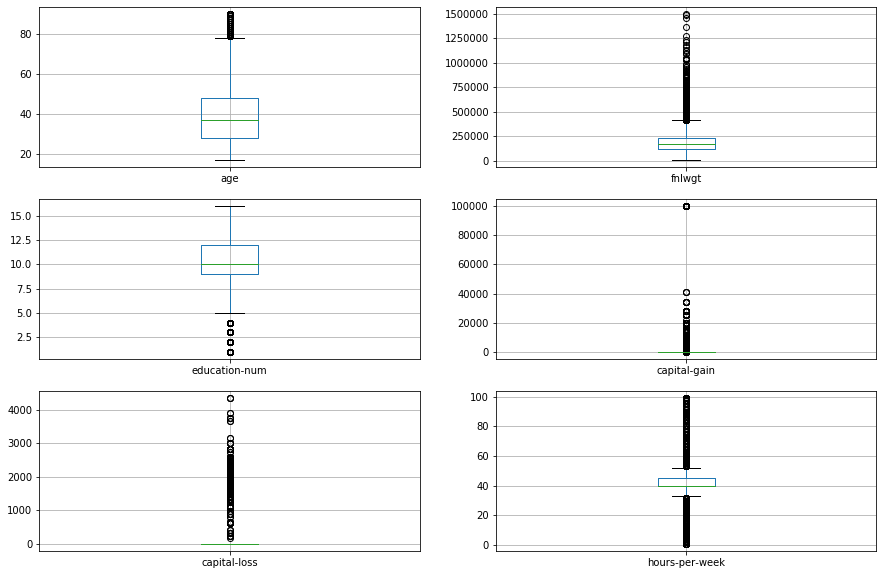

In [133]:
f, ax = plt.subplots(3, 2, figsize=(15, 10))

df.boxplot('age',            ax=ax[0][0])
df.boxplot('fnlwgt',         ax=ax[0][1])
df.boxplot('education-num',  ax=ax[1][0])
df.boxplot('capital-gain',   ax=ax[1][1])
df.boxplot('capital-loss',   ax=ax[2][0])
df.boxplot('hours-per-week', ax=ax[2][1])

plt.show()

### Categorical Attributes

The categorical attributes are:
- workclass
- education
- marital-status
- ocupation
- relationship
- race
- sex
- native-country

In [139]:
for feat in categorical_features:
    print(f'{feat:14} has {len(df[feat].unique()):2} unique values')

IndexError: Index dimension must be <= 2

In [140]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
df = ohe.fit_transform(df[categorical_features[4:5]])

df

TypeError: cannot perform reduce with flexible type

### Numerical Attributes

The numerical features are.
- age
- fnlwgt
- education-num
- capital-gain
- capital-loss
- hours-per-week

In [142]:
for feat in numerical_features:
    print(f'Range({feat}) in [{df[feat].min()}, {df[feat].max()}]')

Range(age) in [17.0, 90.0]
Range(fnlwgt) in [12285.0, 1490400.0]
Range(education-num) in [1.0, 16.0]
Range(capital-gain) in [0.0, 99999.0]
Range(capital-loss) in [0.0, 4356.0]
Range(hours-per-week) in [1.0, 99.0]


In [151]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Agglomerative Clustering

In [120]:
from sklearn.cluster import AgglomerativeClustering

linkages = ['complete', 'average', 'single']
affinities = ['euclidean', 'cosine']

for linkage in linkages:
    for affinity in affinities:
        ac = AgglomerativeClustering(affinity=affinity, linkage=linkage)